In [3]:
.libPaths("/home/jut268/.conda/envs/multiome/lib/R/library")
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(dplyr)
library(data.table)

library(ggplot2)
library(ggrepel)
library(patchwork)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff

In [4]:
make_signac_obj = function(counts_path, metadata_path, fragments_path) {

    print("making object...")
    counts <- Read10X_h5(filename = counts_path)

    metadata <- read.csv(
    file = metadata_path,
    header = TRUE,
    row.names = 1
    )

    chrom_assay <- CreateChromatinAssay(
    counts = counts,
    sep = c(":", "-"),
    fragments = fragments_path,
    min.cells = 10,
    min.features = 200
    )

    brain_obj <- CreateSeuratObject(
    counts = chrom_assay,
    meta.data = metadata,
    assay = "peaks"
    )

    print("adding gene annotations...")
    # extract gene annotations from EnsDb
    annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

    # change to UCSC style since the data was mapped to hg19
    seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
    genome(annotations) <- "hg38"

    # add the gene information to the object
    Annotation(brain_obj) <- annotations

    print("calculating qc metrics...")
    # compute nucleosome signal score per cell
    brain_obj <- NucleosomeSignal(brain_obj)

    # compute TSS enrichment score per cell
    brain_obj <- TSSEnrichment(brain_obj, fast = FALSE)

    # add blacklist ratio and fraction of reads in peaks
    brain_obj$pct_reads_in_peaks <- brain_obj$peak_region_fragments / brain_obj$passed_filters * 100
    brain_obj$blacklist_ratio <- brain_obj$blacklist_region_fragments / brain_obj$peak_region_fragments

    return(brain_obj)
}

obtain_metadata_tbl = function(clone_path, sample_id_name) {
    
    # read in clone information
    #clone_ids = fread("/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138515_RL2367_1m_snATAC_/AMULET_adj_results/subclones_annot.tsv", sep = "\t") %>% select(c("cell", "annot"))
    clone_ids = fread(clone_path, sep = "\t") %>% select(c("cell", "annot"))

    # change cell ids to barcode
    split_id = function(id) {
        unlist(strsplit(id, "cell-"))[2]
    }

    split_ids = sapply(clone_ids$cell, split_id) %>% unname()
    clone_ids$barcode = split_ids

    # read in cell type labels
    #cell_type_labels = fread("/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/Brain_cell_type_labels_NEW.tsv", sep="\t") #%>% select(c("barcode", "predictedGroup"))
    cell_type_labels = fread("/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/Brain_cell_type_labels_NEW.tsv", sep="\t") #%>% select(c("barcode", "predictedGroup"))

    # only keep barcodes for this sample
    sample_labels = cell_type_labels %>% filter(sample_id == sample_id_name) %>% select(c("barcode", "sample_id", "predictedGroup"))

    sample_metadata = left_join(clone_ids, sample_labels, by = "barcode") %>% select("barcode", "annot", "predictedGroup")

    return(sample_metadata)
}

add_cnv_info = function(sample_metadata, CNV_barcode_path) {
     # add CNV ids
    CNV_ids = fread(CNV_barcode_path, sep = "\t") %>% select(c("cell", "cnv_id"))

    split_id = function(id) {
        unlist(strsplit(id, "cell-"))[2]
    }

    CNV_ids$barcode = sapply(CNV_ids$cell, split_id) %>% unname()

    CNV_ids = CNV_ids %>% select(c("barcode", "cnv_id"))

    sample_metadata = left_join(sample_metadata, CNV_ids, by = "barcode") %>% mutate(cnv_status = case_when(is.na(cnv_id) ~ "CNV-", cnv_id!="none" ~ "CNV+"))

    return(sample_metadata)
}

annotate_and_subset_obj = function(brain_obj, sample_metadata, add_clones) {

    brain_obj_subset = subset(brain_obj, cells = sample_metadata$barcode)

    brain_obj_names = brain_obj_subset[[]] %>% rownames()

    sample_metadata_tbl = sample_metadata %>% slice(match(brain_obj_names, barcode)) #%>% select(c("barcode", "annot"))

    brain_obj_subset$clone_id = sample_metadata_tbl$annot
    brain_obj_subset$cell_id = sample_metadata_tbl$predictedGroup

    if (add_clones) {
        brain_obj_subset$CNV_id = sample_metadata_tbl$cnv_id
        brain_obj_subset$CNV_status = sample_metadata_tbl$cnv_status
    }


    # set identity to clones
    brain_obj_subset[["old.ident"]] = Idents(brain_obj_subset)
    "clone_id" -> Idents(brain_obj_subset)

    levels(brain_obj_subset) <- c("Clone1", "Clone2", "Clone3", "Clone4", "Clone5", "Clone6")

    return(brain_obj_subset)
    
}

get_gene_activities = function(brain_obj) {
    
    gene.activities <- GeneActivity(brain_obj)
    brain_obj[['RNA']] <- CreateAssayObject(counts = gene.activities)
    brain_obj <- NormalizeData(
    object = brain_obj,
    assay = 'RNA',
    normalization.method = 'LogNormalize',
    scale.factor = median(brain_obj$nCount_RNA)
)
    return(brain_obj)
}

cluster_and_umap = function(brain_obj) {
    brain_obj <- RunTFIDF(brain_obj) %>% FindTopFeatures(min.cutoff = 'q0') %>% RunSVD()
    brain_obj <- RunUMAP(object = brain_obj, reduction = 'lsi', dims = 2:30) %>% FindNeighbors(reduction = 'lsi', dims = 2:30) %>% FindClusters(verbose = FALSE, algorithm = 3, resolution = 0.5)

    return(brain_obj)
}


In [5]:
counts_path = "/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/count_matrices/RL1914_filtered_peak_bc_matrix.h5"
metadata_path = "/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/singlecell_qc_files/GSM5138518_RL1914_3m_snATAC_singlecell.csv.gz"
fragments_path = "/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/GSM5138518_RL1914_3m_snATAC_fragments.tsv.gz"

clone_path = "/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138518_RL1914_3m_snATAC_/AMULET_adj_results/subclones_annot.tsv"
sample_id = "RL1914"
CNV_barcode_path = "/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138518_RL1914_3m_snATAC_/AMULET_adj_results/cnv_barcodes.tsv"

In [6]:
brain_obj = make_signac_obj(counts_path, metadata_path, fragments_path)
metadata_tbl = obtain_metadata_tbl(clone_path, sample_id) %>% add_cnv_info(CNV_barcode_path)

[1] "making object..."


Computing hash



[1] "adding gene annotations..."


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

[1] "calculating qc metrics..."


Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score

Warning message in fread(clone_path, sep = "\t"):
"Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in fread("/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/Brain_cell_type_labels_NEW.tsv", :
"Detected 3 column names but the data has 4 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


In [7]:
brain_obj_subset = annotate_and_subset_obj(brain_obj, metadata_tbl, add_clones=TRUE)

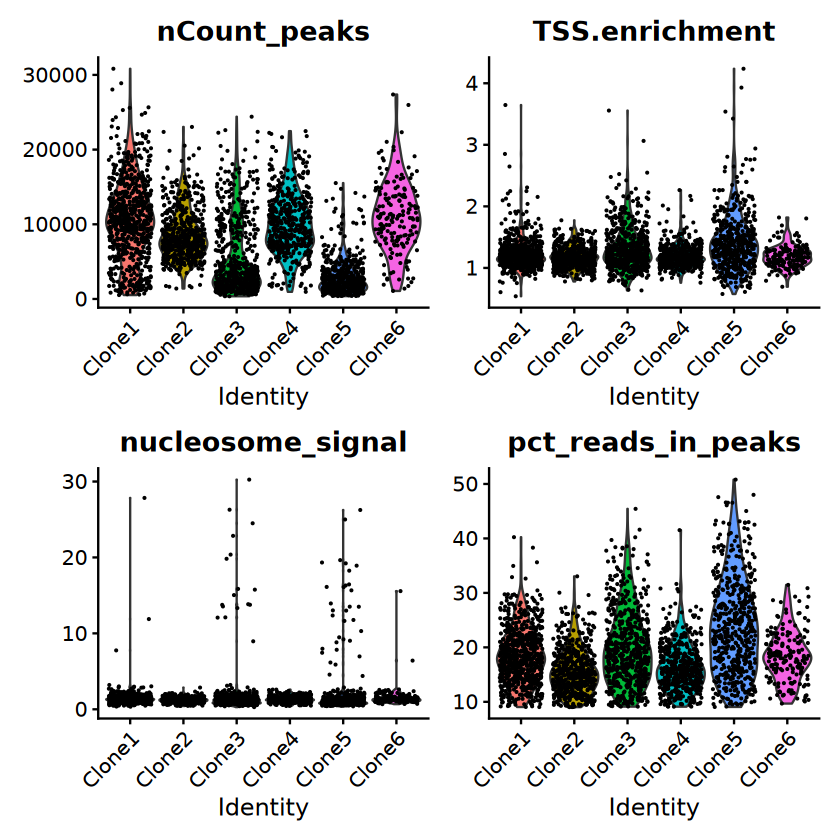

In [8]:
VlnPlot(
  object = brain_obj_subset,
  features = c('nCount_peaks', 'TSS.enrichment', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 2
)

In [9]:
brain_obj_subset2 = subset(
  x = brain_obj_subset,
  subset = nCount_peaks > 8000 &
    nCount_peaks < 40000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 2.5 &
    TSS.enrichment > 1
)

brain_obj_subset2

An object of class Seurat 
61407 features across 1084 samples within 1 assay 
Active assay: peaks (61407 features, 0 variable features)
 2 layers present: counts, data

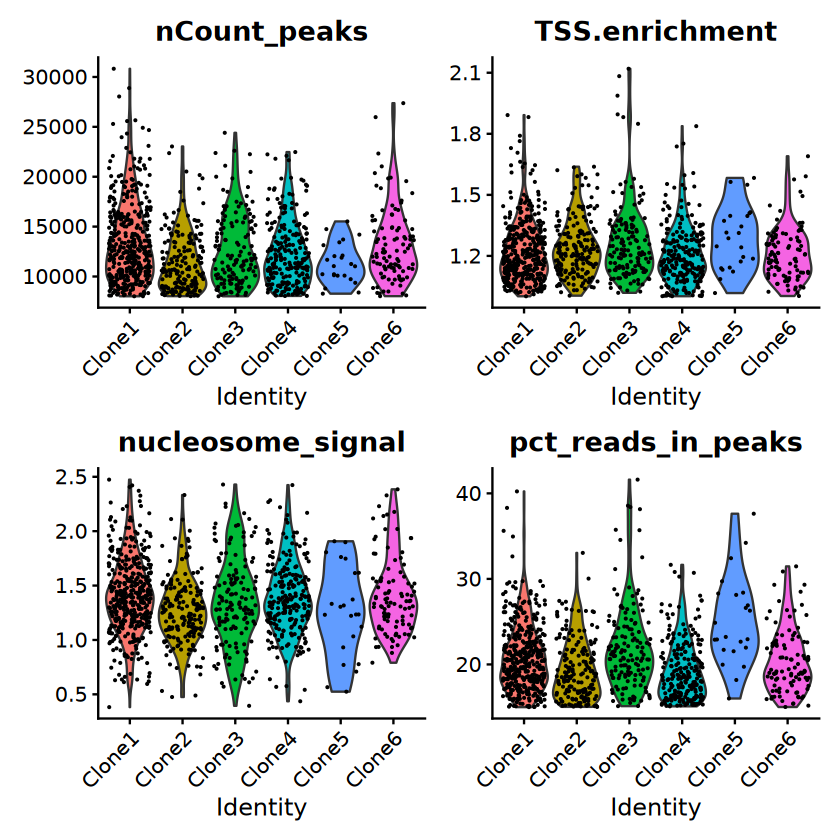

In [10]:
VlnPlot(
  object = brain_obj_subset2,
  features = c('nCount_peaks', 'TSS.enrichment', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 2
)

In [11]:
brain_obj_subset_umap = get_gene_activities(brain_obj_subset2) %>% cluster_and_umap()

Extracting gene coordinates

Extracting reads overlapping genomic regions

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
11:45:02 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

11:45:02 Read 1084 rows and found 29 numeric columns

11:45:02 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

11:45:02 Building Annoy index wit

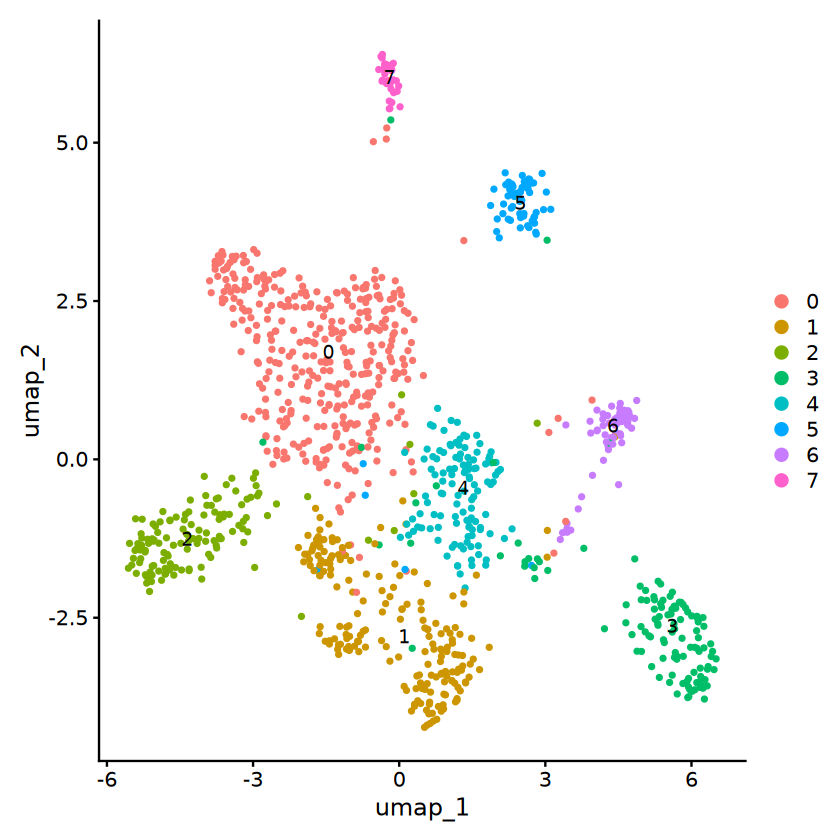

In [12]:
DimPlot(object = brain_obj_subset_umap, label = TRUE) 

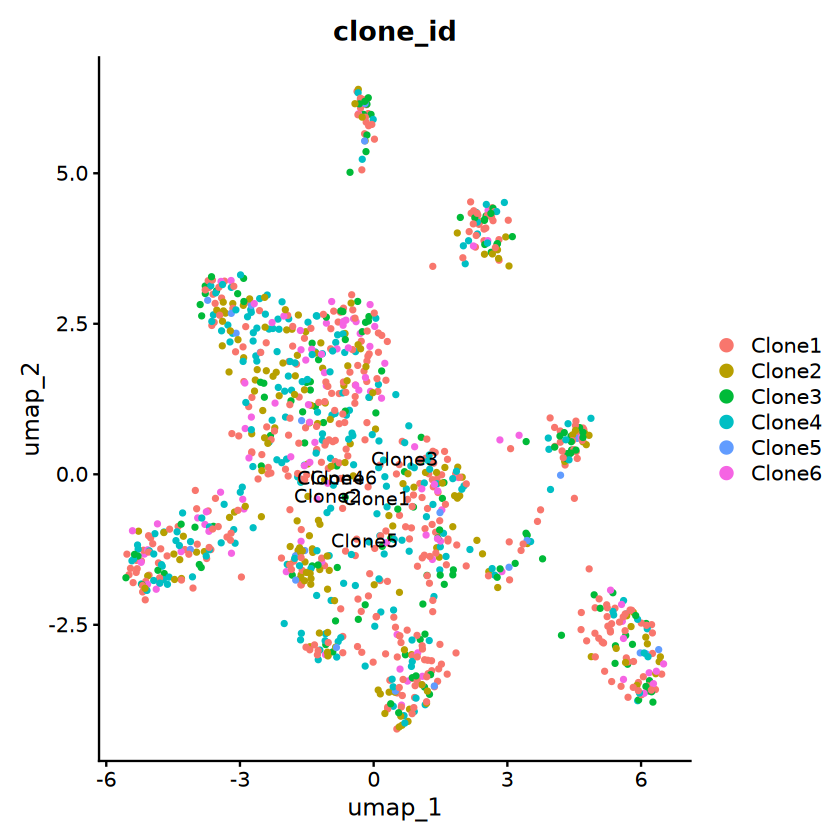

In [13]:
DimPlot(object = brain_obj_subset_umap, group.by="clone_id", label = TRUE) 

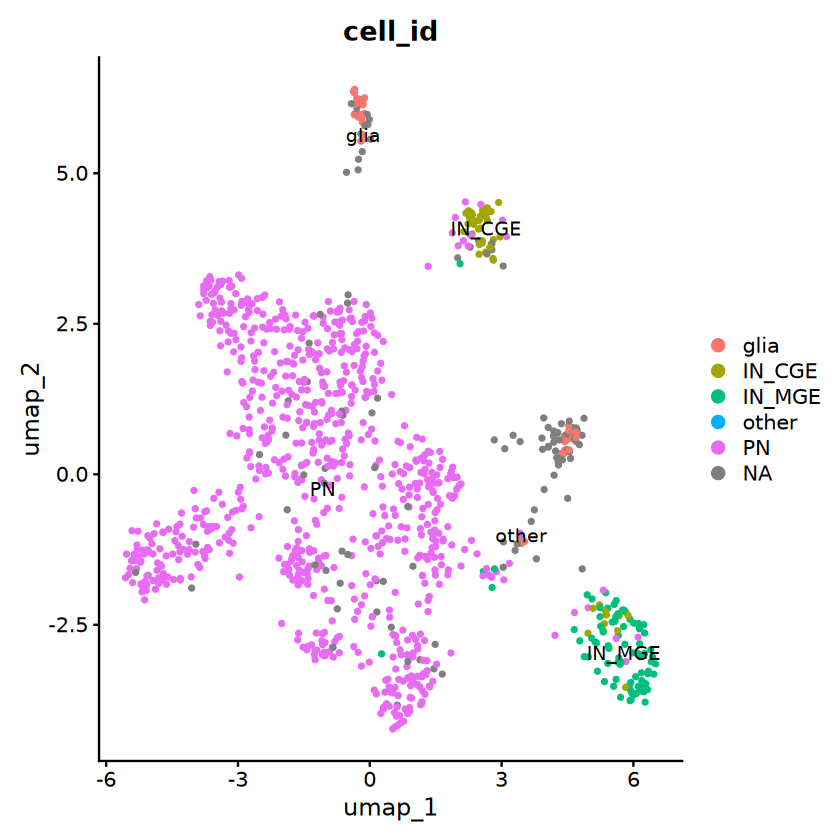

In [14]:
DimPlot(object = brain_obj_subset_umap, group.by="cell_id", label = TRUE) 

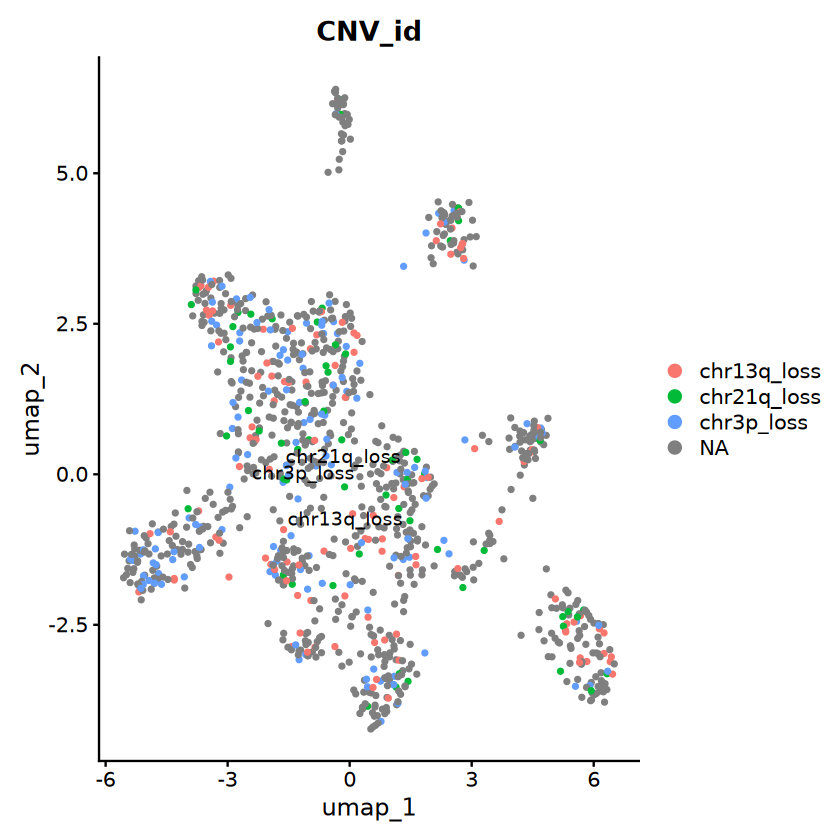

In [22]:
DimPlot(object = brain_obj_subset_umap, group.by="CNV_id", label = TRUE) 

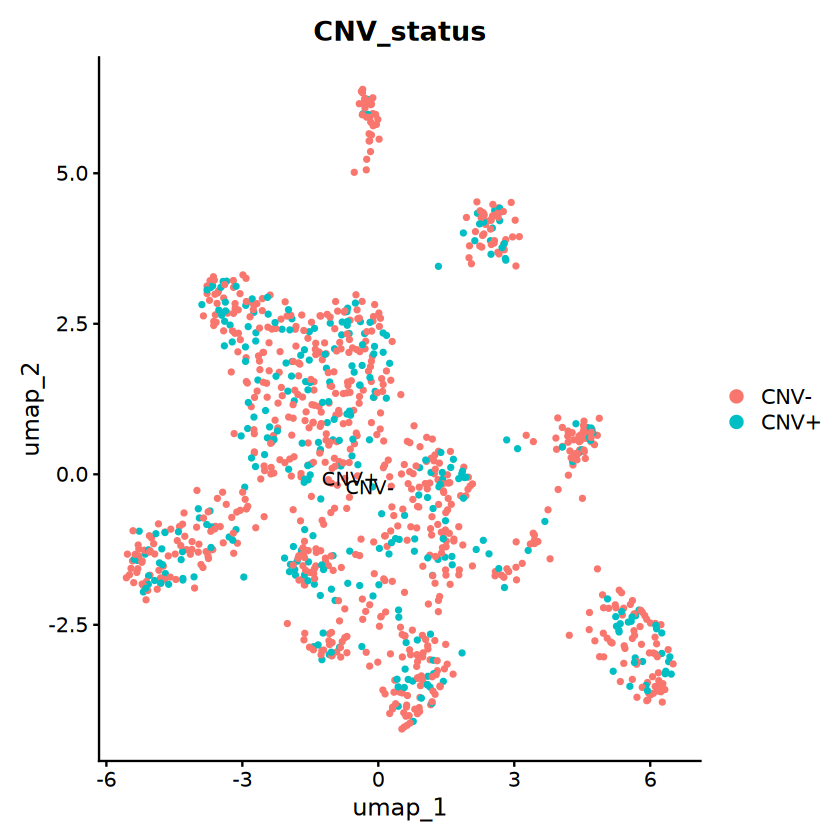

In [23]:
DimPlot(object = brain_obj_subset_umap, group.by="CNV_status", label = TRUE) 

In [24]:
saveRDS(brain_obj_subset_umap, "/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138518_RL1914_3m_snATAC_/AMULET_adj_results/annotated_signac_object.rds")

: 

# filter out technical artifact CNVs

In [2]:
obtain_metadata_tbl = function(clone_path, sample_id_name) {
    
    # read in clone information
    #clone_ids = fread("/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138515_RL2367_1m_snATAC_/AMULET_adj_results/subclones_annot.tsv", sep = "\t") %>% select(c("cell", "annot"))
    clone_ids = fread(clone_path, sep = "\t") %>% select(c("cell", "annot"))

    # change cell ids to barcode
    split_id = function(id) {
        unlist(strsplit(id, "cell-"))[2]
    }

    split_ids = sapply(clone_ids$cell, split_id) %>% unname()
    clone_ids$barcode = split_ids

    # read in cell type labels
    #cell_type_labels = fread("/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/Brain_cell_type_labels_NEW.tsv", sep="\t") #%>% select(c("barcode", "predictedGroup"))
    cell_type_labels = fread("/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/Brain_cell_type_labels_NEW.tsv", sep="\t") #%>% select(c("barcode", "predictedGroup"))

    # only keep barcodes for this sample
    sample_labels = cell_type_labels %>% filter(sample_id == sample_id_name) %>% select(c("barcode", "sample_id", "predictedGroup"))

    sample_metadata = left_join(clone_ids, sample_labels, by = "barcode") %>% select("barcode", "annot", "predictedGroup")

    return(sample_metadata)
}

add_cnv_info = function(sample_metadata, CNV_barcode_path) {
     # add CNV ids
    CNV_ids = fread(CNV_barcode_path, sep = "\t") %>% select(c("cell", "cnv_id"))

    split_id = function(id) {
        unlist(strsplit(id, "cell-"))[2]
    }

    CNV_ids$barcode = sapply(CNV_ids$cell, split_id) %>% unname()

    CNV_ids = CNV_ids %>% select(c("barcode", "cnv_id"))

    sample_metadata = left_join(sample_metadata, CNV_ids, by = "barcode") %>% mutate(cnv_status = case_when(is.na(cnv_id) ~ "CNV-", cnv_id!="none" ~ "CNV+"))

    return(sample_metadata)
}

In [3]:
results_dir = "/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138518_RL1914_3m_snATAC_/AMULET_adj_results"
sample_id = "RL1914"

clone_path = paste0(results_dir, "/subclones_annot.tsv")
no_13_CNV_barcode_path = paste0(results_dir, "/cnv_barcodes_no13.tsv")
no_13_or_3_CNV_barcode_path = paste0(results_dir, "/cnv_barcodes_no13_or_3.tsv")
signac_path = paste0(results_dir, "/annotated_signac_object.rds")

In [5]:
brain_obj = readRDS(signac_path)
no_13_sample_metadata = obtain_metadata_tbl(clone_path, sample_id) %>% add_cnv_info(no_13_CNV_barcode_path)
no_13_or_3_sample_metadata = obtain_metadata_tbl(clone_path, sample_id) %>% add_cnv_info(no_13_or_3_CNV_barcode_path)

brain_obj_names = brain_obj[[]] %>% rownames()

no_13_sample_metadata_tbl = no_13_sample_metadata %>% slice(match(brain_obj_names, barcode)) 
no_13_or_3_sample_metadata_tbl = no_13_or_3_sample_metadata %>% slice(match(brain_obj_names, barcode))

brain_obj$CNV_id_no13 = no_13_sample_metadata_tbl$cnv_id
brain_obj$CNV_status_no13 = no_13_sample_metadata_tbl$cnv_status

brain_obj$CNV_id_no13_or_3 = no_13_or_3_sample_metadata_tbl$cnv_id
brain_obj$CNV_status_no13_or_3 = no_13_or_3_sample_metadata_tbl$cnv_status

saveRDS(brain_obj, paste0(results_dir, "/annotated_signac_object_filtered_CNVs.rds"))

Warning message in fread(clone_path, sep = "\t"):
"Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in fread("/home/jut268/julie/scATAC-seq_CNV_project/data/scATAC-seq_datasets/Brain/GSE168408/Brain_cell_type_labels_NEW.tsv", :
"Detected 3 column names but the data has 4 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in fread(clone_path, sep = "\t"):
"Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guess

In [7]:
readRDS(signac_path)

An object of class Seurat 
81014 features across 1084 samples within 2 assays 
Active assay: peaks (61407 features, 61407 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [6]:
brain_obj

An object of class Seurat 
81014 features across 1084 samples within 2 assays 
Active assay: peaks (61407 features, 61407 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# get qc violin plot

In [1]:
brain_obj = readRDS("/home/jut268/julie/scATAC-seq_CNV_project/results/Brain/GSE168408/GSM5138518_RL1914_3m_snATAC_/AMULET_adj_results/annotated_signac_object.rds")

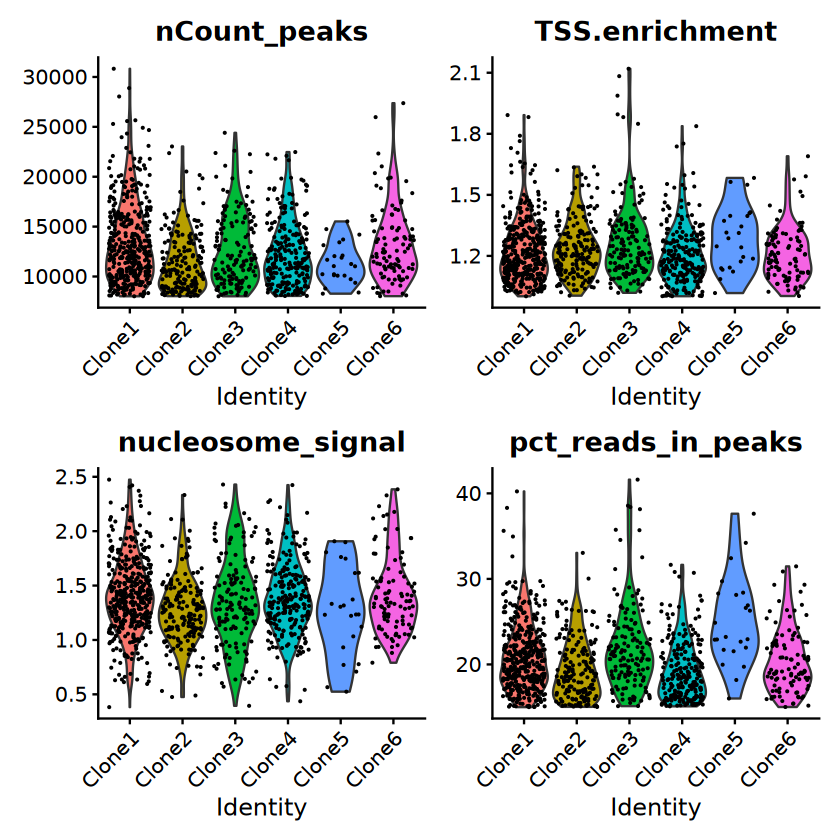

In [5]:
VlnPlot(
  object = brain_obj,
  features = c('nCount_peaks', 'TSS.enrichment', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 2,
  group.by="clone_id"
)

In [6]:
qc_plot_path = "/home/jut268/julie/scATAC-seq_CNV_project/analysis/signac/Brain_analyses/qc_violin_plots"
ggsave(paste0(qc_plot_path, "/3m_plot.png"))

Saving 6.67 x 6.67 in image
